In [2]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

load data

In [323]:
merged_df = pd.read_csv('data/main/merged_data.csv')

In [310]:
#merged_df = merged_df[merged_df['industry_1'] == 'Erbringung von sonstigen wirtschaftlichen Dienstleistungen']

In [324]:
merged_df = merged_df[merged_df['size'] == 'Kleine und mittlere Unternehmen']

In [ ]:
list(merged_df.columns)

In [325]:
ratios = ['current_ratio','qick_ratio','cash_ratio','debt2equity_ratio','debt2asset_ratio','equity_ratio']
types = ['grant','loan']
results_dict = {}

In [326]:
for year in [2020,2021]:

    for id, type in enumerate(types, start=1):
        type_inverse_year = types[id-2] + '_' + str(year)
        type_year = type + '_' + str(year)
        data_unconfounded = merged_df[merged_df[type_inverse_year].isnull()]

        if year == 2021: # Remove companies that received other aid due to possible confounding
                data_unconfounded = data_unconfounded[data_unconfounded[('grant'+'_'+ str(year-1))].isnull()] ###
                data_unconfounded = data_unconfounded[data_unconfounded[('loan'+'_'+ str(year-1))].isnull()] ###
        
        results = {}
        

        for ratio in ratios:
            

            ratio_year_prior = ratio + '_' + str(year-1)
            ratio_year = ratio + '_' + str(year)

            data_dd = data_unconfounded[[ratio_year_prior , ratio_year, type_year]]
            data_dd['treatment_group'] = np.where(data_dd[type_year].isna() , 0, 1)
            data_dd = data_dd.drop(type_year, axis=1)
            data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
            data_dd = data_dd.dropna()

            # data before the treatment
            df_before = data_dd[[ratio_year_prior, 'treatment_group']]
            df_before['t'] = 0
            df_before.columns = [ratio, 'treatment_group', 'time']

            # data after the treatment
            df_after = data_dd[[ratio_year, 'treatment_group']]
            df_after['t'] = 1
            df_after.columns = [ratio, 'treatment_group', 'time']

            # data for regression
            df_reg = pd.concat([df_before, df_after])

            # create the interaction 
            df_reg['interaction'] = df_reg.treatment_group * df_reg.time

            # drop extrem outliers
            df_reg = df_reg[df_reg[ratio] > 0 ]
            df_reg = df_reg.drop(df_reg[df_reg[ratio] > df_reg[ratio].quantile(.95)].index)
            

            from statsmodels.formula.api import ols
            formular = ratio + ' ~ treatment_group + time + interaction' 
            #print(formular)
            ols = ols(formular, data=df_reg).fit()
            
            #print(year,type,ratio)
            #print(ols.params['interaction'].round(4) , ols.pvalues['interaction'].round(3))
            #print(ols.summary())

            results[ratio] = ols.params['interaction'].round(4) , (ols.pvalues['interaction'].round(3))
        results_dict[type_year] = results

In [266]:
pd.DataFrame.from_dict(results_dict, orient='index')

,current_ratio,qick_ratio,cash_ratio,debt2equity_ratio,debt2asset_ratio,equity_ratio
grant_2020,"(-0.1659, 0.195)","(-0.0907, 0.435)","(-0.0058, 0.532)","(0.5711, 0.039)","(0.0363, 0.026)","(-0.0096, 0.49)"
loan_2020,"(0.1518, 0.001)","(0.0911, 0.028)","(0.0651, 0.0)","(1.0919, 0.0)","(0.0768, 0.0)","(-0.0575, 0.0)"
grant_2021,"(-0.0447, 0.832)","(0.0254, 0.895)","(0.0928, 0.0)","(-0.3986, 0.115)","(-0.0306, 0.097)","(0.0128, 0.435)"
loan_2021,"(0.2638, 0.072)","(0.1945, 0.11)","(0.0389, 0.0)","(0.6902, 0.075)","(0.0567, 0.002)","(-0.0454, 0.002)"


In [327]:
pd.DataFrame.from_dict(results_dict, orient='index')

,current_ratio,qick_ratio,cash_ratio,debt2equity_ratio,debt2asset_ratio,equity_ratio
grant_2020,"(-0.2559, 0.067)","(-0.2205, 0.082)","(-0.0058, 0.547)","(0.4802, 0.073)","(0.0376, 0.023)","(-0.0119, 0.408)"
loan_2020,"(0.0679, 0.312)","(0.0308, 0.605)","(0.0577, 0.0)","(0.976, 0.0)","(0.0784, 0.0)","(-0.0618, 0.0)"
grant_2021,"(-0.2181, 0.383)","(-0.155, 0.499)","(0.0758, 0.0)","(-0.2636, 0.349)","(-0.0093, 0.665)","(0.0037, 0.848)"
loan_2021,"(-0.0844, 0.694)","(-0.0441, 0.807)","(0.0113, 0.391)","(0.8434, 0.062)","(0.0712, 0.003)","(-0.0507, 0.014)"


### Diff and Diff 2020

#### 2020 grants

##### current ratio

In [271]:
# Remove companies that received loans in 2020 due to possible confounding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['current_ratio_2019','current_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()


# data before the treatment
df_before = data_dd[['current_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['current_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['current_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['current_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['current_ratio'] > df_reg['current_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['current_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('current_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          current_ratio   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     64.42
Date:                Thu, 20 Apr 2023   Prob (F-statistic):           2.19e-41
Time:                        10:32:01   Log-Likelihood:                -34165.
No. Observations:               15338   AIC:                         6.834e+04
Df Residuals:                   15334   BIC:                         6.837e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.0455      0.027     

##### quick ratio

In [232]:
# Remove companies that received loans in 2020 due to possible confounding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['qick_ratio_2019','qick_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['qick_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['qick_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['qick_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['qick_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['qick_ratio'] > df_reg['qick_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['qick_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('qick_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             qick_ratio   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     61.33
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           2.07e-39
Time:                        23:34:51   Log-Likelihood:                -32751.
No. Observations:               15356   AIC:                         6.551e+04
Df Residuals:                   15352   BIC:                         6.554e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.6322      0.024     

##### cash ratio

In [8]:
# Remove companies that received loans in 2020 due to possible confounding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['cash_ratio_2019','cash_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['cash_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['cash_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['cash_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['cash_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg[df_reg['cash_ratio'] > 0 ] # 0 values are not plausable
df_reg = df_reg.drop(df_reg[df_reg['cash_ratio'] > df_reg['cash_ratio'].quantile(.95)].index)


from statsmodels.formula.api import ols
ols = ols('cash_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             cash_ratio   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     23.85
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           2.16e-15
Time:                        20:26:54   Log-Likelihood:                 6280.1
No. Observations:               15167   AIC:                        -1.255e+04
Df Residuals:                   15163   BIC:                        -1.252e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1618      0.002     

##### debt to equity ratio

In [9]:
# Remove companies that received loans in 2020 due to possible confounding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['debt2equity_ratio_2019','debt2equity_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2equity_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2equity_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2equity_ratio'] > df_reg['debt2equity_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['debt2equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:      debt2equity_ratio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.635
Date:                Wed, 19 Apr 2023   Prob (F-statistic):              0.179
Time:                        20:26:54   Log-Likelihood:                -37471.
No. Observations:               13022   AIC:                         7.495e+04
Df Residuals:                   13018   BIC:                         7.498e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.9009      0.056     

##### debt to asset ratio

In [10]:
# Remove companies that received loans in 2020 due to possible confounding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['debt2asset_ratio_2019','debt2asset_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2asset_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2asset_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2asset_ratio'] > df_reg['debt2asset_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['debt2asset_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2asset_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:       debt2asset_ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.963
Date:                Wed, 19 Apr 2023   Prob (F-statistic):             0.0308
Time:                        20:26:54   Log-Likelihood:                -3560.9
No. Observations:               16949   AIC:                             7130.
Df Residuals:                   16945   BIC:                             7161.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5591      0.003    1

##### equity ratio

In [11]:
# Remove companies that received loans in 2020 due to possible confounding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['equity_ratio_2019','equity_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['equity_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['equity_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['equity_ratio'] > df_reg['equity_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:           equity_ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.357
Date:                Wed, 19 Apr 2023   Prob (F-statistic):            0.00110
Time:                        20:26:54   Log-Likelihood:                -968.33
No. Observations:               14730   AIC:                             1945.
Df Residuals:                   14726   BIC:                             1975.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3735      0.003    1

#### 2020 loans

##### current ratio

In [12]:
# Remove companies that received loans in 2020 due to possible confounding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['current_ratio_2019','current_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()
data_dd = data_dd.drop(data_dd[data_dd['current_ratio_2019'] > data_dd['current_ratio_2019'].quantile(.95)].index)


# data before the treatment
df_before = data_dd[['current_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['current_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['current_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['current_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['current_ratio'] > df_reg['current_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['current_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('current_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          current_ratio   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     180.2
Date:                Wed, 19 Apr 2023   Prob (F-statistic):          1.60e-115
Time:                        20:26:54   Log-Likelihood:                -40940.
No. Observations:               24022   AIC:                         8.189e+04
Df Residuals:                   24018   BIC:                         8.192e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.6362      0.017     

##### quick ratio

In [13]:
# Remove companies that received loans in 2020 due to possible confounding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['qick_ratio_2019','qick_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['qick_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['qick_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['qick_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['qick_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['qick_ratio'] > df_reg['qick_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['qick_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('qick_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             qick_ratio   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     220.0
Date:                Wed, 19 Apr 2023   Prob (F-statistic):          6.31e-141
Time:                        20:26:54   Log-Likelihood:                -48986.
No. Observations:               25622   AIC:                         9.798e+04
Df Residuals:                   25618   BIC:                         9.801e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.5002      0.020     

##### cash ratio

In [14]:
# Remove companies that received loans in 2020 due to possible confounding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['cash_ratio_2019','cash_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['cash_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['cash_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['cash_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['cash_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg[df_reg['cash_ratio'] > 0 ] # 0 values are not plausable
df_reg = df_reg.drop(df_reg[df_reg['cash_ratio'] > df_reg['cash_ratio'].quantile(.95)].index)

from statsmodels.formula.api import ols
ols = ols('cash_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             cash_ratio   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     221.2
Date:                Wed, 19 Apr 2023   Prob (F-statistic):          1.25e-141
Time:                        20:26:54   Log-Likelihood:                 13375.
No. Observations:               25284   AIC:                        -2.674e+04
Df Residuals:                   25280   BIC:                        -2.671e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1517      0.002     

##### debt to equity ratio

In [15]:
# Remove companies that received loans in 2020 due to possible confounding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['debt2equity_ratio_2019','debt2equity_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2equity_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2equity_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2equity_ratio'] > df_reg['debt2equity_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['debt2equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:      debt2equity_ratio   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     169.7
Date:                Wed, 19 Apr 2023   Prob (F-statistic):          9.09e-109
Time:                        20:26:54   Log-Likelihood:                -66317.
No. Observations:               22111   AIC:                         1.326e+05
Df Residuals:                   22107   BIC:                         1.327e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.0230      0.063     

##### debt to asset ratio

In [16]:
# Remove companies that received loans in 2020 due to possible confounding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['debt2asset_ratio_2019','debt2asset_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2asset_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2asset_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2asset_ratio'] > df_reg['debt2asset_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['debt2asset_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2asset_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:       debt2asset_ratio   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     422.3
Date:                Wed, 19 Apr 2023   Prob (F-statistic):          2.19e-268
Time:                        20:26:55   Log-Likelihood:                -3290.4
No. Observations:               28308   AIC:                             6589.
Df Residuals:                   28304   BIC:                             6622.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5591      0.003    1

##### equity ratio

In [17]:
# Remove companies that received loans in 2020 due to possible confounding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['equity_ratio_2019','equity_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['equity_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['equity_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['equity_ratio'] > df_reg['equity_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:           equity_ratio   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     485.3
Date:                Wed, 19 Apr 2023   Prob (F-statistic):          1.55e-306
Time:                        20:26:55   Log-Likelihood:                 1060.8
No. Observations:               25056   AIC:                            -2114.
Df Residuals:                   25052   BIC:                            -2081.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3727      0.003    1

###

### Diff and Diff 2021

#### 2021 grants

##### current ratio

In [18]:
# Remove companies that received loans in 2021 due to possible confounding
data_dd = merged_df[merged_df['loan_2021'].isnull()]
data_dd = data_dd[data_dd['grant_2020'].isnull()] ###
data_dd = data_dd[data_dd['loan_2020'].isnull()] ###
data_dd = data_dd[['current_ratio_2020','current_ratio_2021','grant_2021']]
data_dd['treatment_group'] = np.where(data_dd['grant_2021'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2021', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['current_ratio_2020', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['current_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['current_ratio_2021', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['current_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['current_ratio'] > df_reg['current_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['current_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('current_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          current_ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.038
Date:                Wed, 19 Apr 2023   Prob (F-statistic):             0.0279
Time:                        20:26:55   Log-Likelihood:                -16517.
No. Observations:                6356   AIC:                         3.304e+04
Df Residuals:                    6352   BIC:                         3.307e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.8919      0.134     

##### quick ratio

In [19]:
# Remove companies that received loans in 2021 due to possible confounding
data_dd = merged_df[merged_df['loan_2021'].isnull()]
data_dd = data_dd[data_dd['grant_2020'].isnull()] ###
data_dd = data_dd[data_dd['loan_2020'].isnull()] ###
data_dd = data_dd[['qick_ratio_2020','qick_ratio_2021','grant_2021']]
data_dd['treatment_group'] = np.where(data_dd['grant_2021'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2021', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['qick_ratio_2020', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['qick_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['qick_ratio_2021', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['qick_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['qick_ratio'] > df_reg['qick_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['qick_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('qick_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             qick_ratio   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     12.05
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           7.33e-08
Time:                        20:26:55   Log-Likelihood:                -15893.
No. Observations:                6353   AIC:                         3.179e+04
Df Residuals:                    6349   BIC:                         3.182e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.1911      0.122     

##### cash ratio

In [20]:
# Remove companies that received loans in 2021 due to possible confounding
data_dd = merged_df[merged_df['loan_2021'].isnull()]
data_dd = data_dd[data_dd['grant_2020'].isnull()] ###
data_dd = data_dd[data_dd['loan_2020'].isnull()] ###
data_dd = data_dd[['cash_ratio_2020','cash_ratio_2021','grant_2021']]
data_dd['treatment_group'] = np.where(data_dd['grant_2021'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2021', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['cash_ratio_2020', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['cash_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['cash_ratio_2021', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['cash_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['cash_ratio'] > df_reg['cash_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['cash_ratio'] > 0 ] # 0 values are not plausable

from statsmodels.formula.api import ols
ols = ols('cash_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             cash_ratio   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     83.05
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           1.09e-52
Time:                        20:26:55   Log-Likelihood:                 1818.5
No. Observations:                6275   AIC:                            -3629.
Df Residuals:                    6271   BIC:                            -3602.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1821      0.007     

##### debt to equity ratio

In [21]:
# Remove companies that received loans in 2021 due to possible confounding
data_dd = merged_df[merged_df['loan_2021'].isnull()]
data_dd = data_dd[data_dd['grant_2020'].isnull()] ###
data_dd = data_dd[data_dd['loan_2020'].isnull()] ###
data_dd = data_dd[['debt2equity_ratio_2020','debt2equity_ratio_2021','grant_2021']]
data_dd['treatment_group'] = np.where(data_dd['grant_2021'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2021', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2equity_ratio_2020', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2equity_ratio_2021', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2equity_ratio'] > df_reg['debt2equity_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['debt2equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:      debt2equity_ratio   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.121
Date:                Wed, 19 Apr 2023   Prob (F-statistic):            0.00628
Time:                        20:26:55   Log-Likelihood:                -15061.
No. Observations:                5564   AIC:                         3.013e+04
Df Residuals:                    5560   BIC:                         3.016e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.3632      0.161     

##### debt to asset ratio

In [22]:
# Remove companies that received loans in 2021 due to possible confounding
data_dd = merged_df[merged_df['loan_2021'].isnull()]
data_dd = data_dd[data_dd['grant_2020'].isnull()] ###
data_dd = data_dd[data_dd['loan_2020'].isnull()] ###
data_dd = data_dd[['debt2asset_ratio_2020','debt2asset_ratio_2021','grant_2021']]
data_dd['treatment_group'] = np.where(data_dd['grant_2021'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2021', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2asset_ratio_2020', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2asset_ratio_2021', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2asset_ratio'] > df_reg['debt2asset_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['debt2asset_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2asset_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:       debt2asset_ratio   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.372
Date:                Wed, 19 Apr 2023   Prob (F-statistic):            0.00108
Time:                        20:26:55   Log-Likelihood:                -1655.2
No. Observations:                6987   AIC:                             3318.
Df Residuals:                    6983   BIC:                             3346.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5255      0.012     

##### equity ratio

In [23]:
# Remove companies that received loans in 2021 due to possible confounding
data_dd = merged_df[merged_df['loan_2021'].isnull()]
data_dd = data_dd[data_dd['grant_2020'].isnull()] ###
data_dd = data_dd[data_dd['loan_2020'].isnull()] ###
data_dd = data_dd[['equity_ratio_2020','equity_ratio_2021','grant_2021']]
data_dd['treatment_group'] = np.where(data_dd['grant_2021'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2021', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['equity_ratio_2020', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['equity_ratio_2021', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
#df_reg = df_reg.drop(df_reg[df_reg['equity_ratio'] > df_reg['equity_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['equity_ratio'] < 1 ]

from statsmodels.formula.api import ols
ols = ols('equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:           equity_ratio   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.294
Date:                Wed, 19 Apr 2023   Prob (F-statistic):            0.00121
Time:                        20:26:55   Log-Likelihood:                -1219.4
No. Observations:                7019   AIC:                             2447.
Df Residuals:                    7015   BIC:                             2474.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3569      0.011     

#### 2021 loans

##### current ratio

In [24]:
# Remove companies that received loans in 2021 due to possible confounding
data_dd = merged_df[merged_df['grant_2021'].isnull()]
data_dd = data_dd[data_dd['grant_2020'].isnull()] ###
data_dd = data_dd[data_dd['loan_2020'].isnull()] ###
data_dd = data_dd[['current_ratio_2020','current_ratio_2021','loan_2021']]
data_dd['treatment_group'] = np.where(data_dd['loan_2021'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2021', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()


# data before the treatment
df_before = data_dd[['current_ratio_2020', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['current_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['current_ratio_2021', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['current_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['current_ratio'] > df_reg['current_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['current_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('current_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          current_ratio   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     9.181
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           4.82e-06
Time:                        20:26:55   Log-Likelihood:                -6006.1
No. Observations:                2904   AIC:                         1.202e+04
Df Residuals:                    2900   BIC:                         1.204e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.3496      0.081     

##### quick ratio

In [25]:
# Remove companies that received loans in 2021 due to possible confounding
data_dd = merged_df[merged_df['grant_2021'].isnull()]
data_dd = data_dd[data_dd['grant_2020'].isnull()] ###
data_dd = data_dd[data_dd['loan_2020'].isnull()] ###
data_dd = data_dd[['qick_ratio_2020','qick_ratio_2021','loan_2021']]
data_dd['treatment_group'] = np.where(data_dd['loan_2021'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2021', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['qick_ratio_2020', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['qick_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['qick_ratio_2021', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['qick_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['qick_ratio'] > df_reg['qick_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['qick_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('qick_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             qick_ratio   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     13.03
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           1.88e-08
Time:                        20:26:55   Log-Likelihood:                -5419.2
No. Observations:                2897   AIC:                         1.085e+04
Df Residuals:                    2893   BIC:                         1.087e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.7095      0.067     

##### cash ratio

In [26]:
# Remove companies that received loans in 2021 due to possible confounding
data_dd = merged_df[merged_df['grant_2021'].isnull()]
data_dd = data_dd[data_dd['grant_2020'].isnull()] ###
data_dd = data_dd[data_dd['loan_2020'].isnull()] ###
data_dd = data_dd[['cash_ratio_2020','cash_ratio_2021','loan_2021']]
data_dd['treatment_group'] = np.where(data_dd['loan_2021'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2021', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['cash_ratio_2020', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['cash_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['cash_ratio_2021', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['cash_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
#df_reg = df_reg.drop(df_reg[df_reg['cash_ratio'] > df_reg['cash_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['cash_ratio'] > 0 ] # 0 values are not plausable

from statsmodels.formula.api import ols
ols = ols('cash_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             cash_ratio   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     22.85
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           1.26e-14
Time:                        20:26:55   Log-Likelihood:                 943.43
No. Observations:                3068   AIC:                            -1879.
Df Residuals:                    3064   BIC:                            -1855.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2049      0.007     

##### debt to equity ratio

In [27]:
# Remove companies that received loans in 2021 due to possible confounding
data_dd = merged_df[merged_df['grant_2021'].isnull()]
data_dd = data_dd[data_dd['grant_2020'].isnull()] ###
data_dd = data_dd[data_dd['loan_2020'].isnull()] ###
data_dd = data_dd[['debt2equity_ratio_2020','debt2equity_ratio_2021','loan_2021']]
data_dd['treatment_group'] = np.where(data_dd['loan_2021'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2021', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2equity_ratio_2020', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2equity_ratio_2021', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2equity_ratio'] > df_reg['debt2equity_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['debt2equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:      debt2equity_ratio   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     18.44
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           7.76e-12
Time:                        20:26:55   Log-Likelihood:                -7882.1
No. Observations:                2627   AIC:                         1.577e+04
Df Residuals:                    2623   BIC:                         1.580e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.8169      0.213     

##### debt to asset ratio

In [29]:
# Remove companies that received loans in 2021 due to possible confounding
data_dd = merged_df[merged_df['grant_2021'].isnull()]
data_dd = data_dd[data_dd['grant_2020'].isnull()] ###
data_dd = data_dd[data_dd['loan_2020'].isnull()] ###
data_dd = data_dd[['debt2asset_ratio_2020','debt2asset_ratio_2021','loan_2021']]
data_dd['treatment_group'] = np.where(data_dd['loan_2021'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2021', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2asset_ratio_2020', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2asset_ratio_2021', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2asset_ratio'] > df_reg['debt2asset_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['debt2asset_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2asset_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:       debt2asset_ratio   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     61.97
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           6.20e-39
Time:                        20:26:55   Log-Likelihood:                -186.00
No. Observations:                3185   AIC:                             380.0
Df Residuals:                    3181   BIC:                             404.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5248      0.010     

##### equity ratio

In [30]:
# Remove companies that received loans in 2021 due to possible confounding
data_dd = merged_df[merged_df['grant_2021'].isnull()]
data_dd = data_dd[data_dd['grant_2020'].isnull()] ###
data_dd = data_dd[data_dd['loan_2020'].isnull()] ###
data_dd = data_dd[['equity_ratio_2020','equity_ratio_2021','loan_2021']]
data_dd['treatment_group'] = np.where(data_dd['loan_2021'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2021', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['equity_ratio_2020', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['equity_ratio_2021', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['equity_ratio'] > df_reg['equity_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:           equity_ratio   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     64.74
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           1.60e-40
Time:                        20:26:55   Log-Likelihood:                 310.42
No. Observations:                2917   AIC:                            -612.8
Df Residuals:                    2913   BIC:                            -588.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3885      0.009     

### 

### Model

In [31]:
import os
import warnings; warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from causal_curve import GPS_Regressor
from causal_curve import Mediation


%matplotlib inline
pd.options.mode.chained_assignment = None
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [5, 4]

In [32]:
df = merged_df#[['cash_ratio_2020','cash_ratio_2021','assets_2021','industry_1','Zuschuss_2021']]

In [33]:
df = df[df['qick_ratio_2021'] < 15 ]
df = df[df['qick_ratio_2021'] > 0 ]
df = df[df['qick_ratio_2020'] < 15 ]
df = df[df['qick_ratio_2020'] > 0 ]

df = df[df['current_ratio_2021'] < 15 ]
df = df[df['current_ratio_2021'] > 0 ]
df = df[df['current_ratio_2020'] < 15 ]
df = df[df['current_ratio_2020'] > 0 ]

In [34]:
df = df[df['industry_2'] == 'Einzelhandel (ohne Handel mit Kraftfahrzeugen)' ]
df['aid_relative_2021'] = df['grant_2021'] / df['assets_2021']

df['delta_cash_ratio_2021'] = (df['cash_ratio_2021'] - df['cash_ratio_2020'])
df['delta_qick_ratio_2021'] = (df['qick_ratio_2021'] - df['qick_ratio_2020'])
df['delta_current_ratio_2021'] = (df['current_ratio_2021'] - df['current_ratio_2020'])
df['delta_equity_ratio_2021'] = (df['equity_ratio_2021'] - df['equity_ratio_2020'])

#df = df[df['delta_qick_ratio_2021'] < 5 ]
#df = df[df['delta_qick_ratio_2021'] > -5 ]
#df = df[df['delta_current_ratio_2021'] < 5 ]
#df = df[df['delta_current_ratio_2021'] > -5 ]

In [35]:
#condounders = pd.get_dummies(df["industry_1"], prefix='industry', drop_first=True)
#condounders.columns = condounders.columns.str.replace(' ', '_')

condounders = pd.get_dummies(df["size"], prefix='size', drop_first=True)
condounders.columns = condounders.columns.str.replace(' ', '_')

list(condounders.columns)

['size_nur_Großunternehmen']

In [36]:
df = df[['delta_cash_ratio_2021',
    'delta_qick_ratio_2021',
    'delta_current_ratio_2021',
    'delta_equity_ratio_2021',    
    'size',
    'aid_relative_2021']]
#final_df = pd.concat([df,pd.get_dummies(df["industry_1"], prefix='industry', drop_first=True)],axis = 1)
#final_df.columns = final_df.columns.str.replace(' ', '_')
final_df = pd.concat([df,pd.get_dummies(df["size"], prefix='size', drop_first=True)],axis = 1)
final_df.columns = final_df.columns.str.replace(' ', '_')

final_df


from causal_curve import TMLE_Regressor

final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
final_df = final_df.dropna()

final_df = final_df[final_df['aid_relative_2021'] < final_df['aid_relative_2021'].quantile(.95)]
#final_df

In [37]:
# Dictionary to store model results
results_dict = {}

# Potential confounders
potential_confounders = list(condounders.columns)

# Try the cash_ratio model
cash_ratio_tmle = TMLE_Regressor(random_seed=111,bandwidth=10)

cash_ratio_tmle.fit(
    T=final_df['aid_relative_2021'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_cash_ratio_2021']
)

results_dict['delta_cash_ratio_2021'] = cash_ratio_tmle.calculate_CDRC()

# Try the qick_ratio model
qick_ratio_tmle = TMLE_Regressor(random_seed=111,bandwidth=10)

qick_ratio_tmle.fit(
    T=final_df['aid_relative_2021'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_qick_ratio_2021']
)

results_dict['delta_qick_ratio_2021'] = qick_ratio_tmle.calculate_CDRC()

# Try the current_ratio model
current_ratio_tmle = TMLE_Regressor(random_seed=111,bandwidth=10)

current_ratio_tmle.fit(
    T=final_df['aid_relative_2021'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_current_ratio_2021']
)

results_dict['delta_current_ratio_2021'] = current_ratio_tmle.calculate_CDRC()

# Try the equity_ratio model
equity_ratio_tmle = TMLE_Regressor(random_seed=111,bandwidth=10)

equity_ratio_tmle.fit(
    T=final_df['aid_relative_2021'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_equity_ratio_2021']
)

results_dict['delta_equity_ratio_2021'] = equity_ratio_tmle.calculate_CDRC()

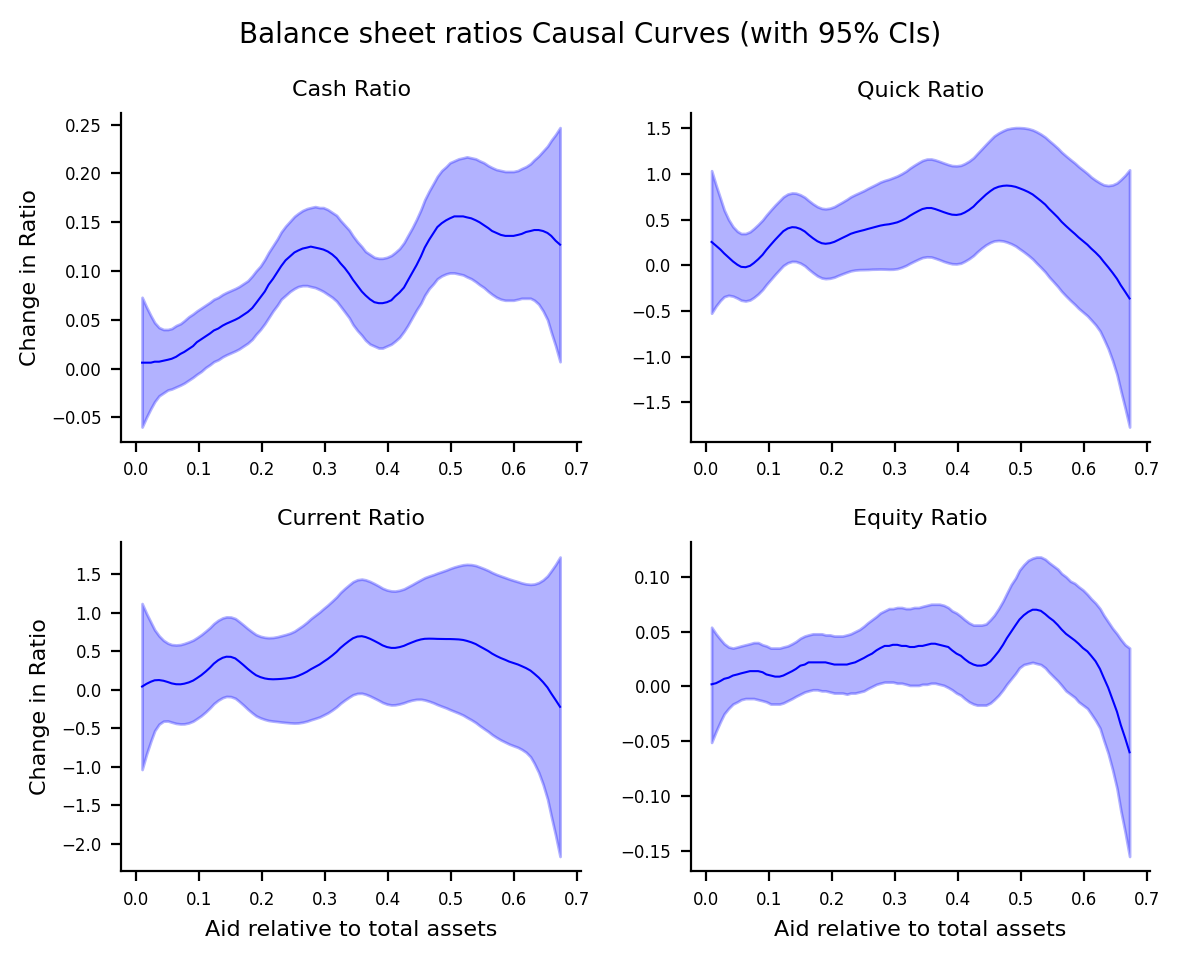

In [38]:
result_class = [['delta_cash_ratio_2021', 'delta_qick_ratio_2021'], ['delta_current_ratio_2021', 'delta_equity_ratio_2021']]

result_name = [['Cash Ratio', 'Quick Ratio'], ['Current Ratio', 'Equity Ratio']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Ratio', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Change in Ratio', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 8)
        axs[1,1].set_xlabel('Aid relative to total assets', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        #axs[i,j].set_xlim(0, 2)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Balance sheet ratios Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

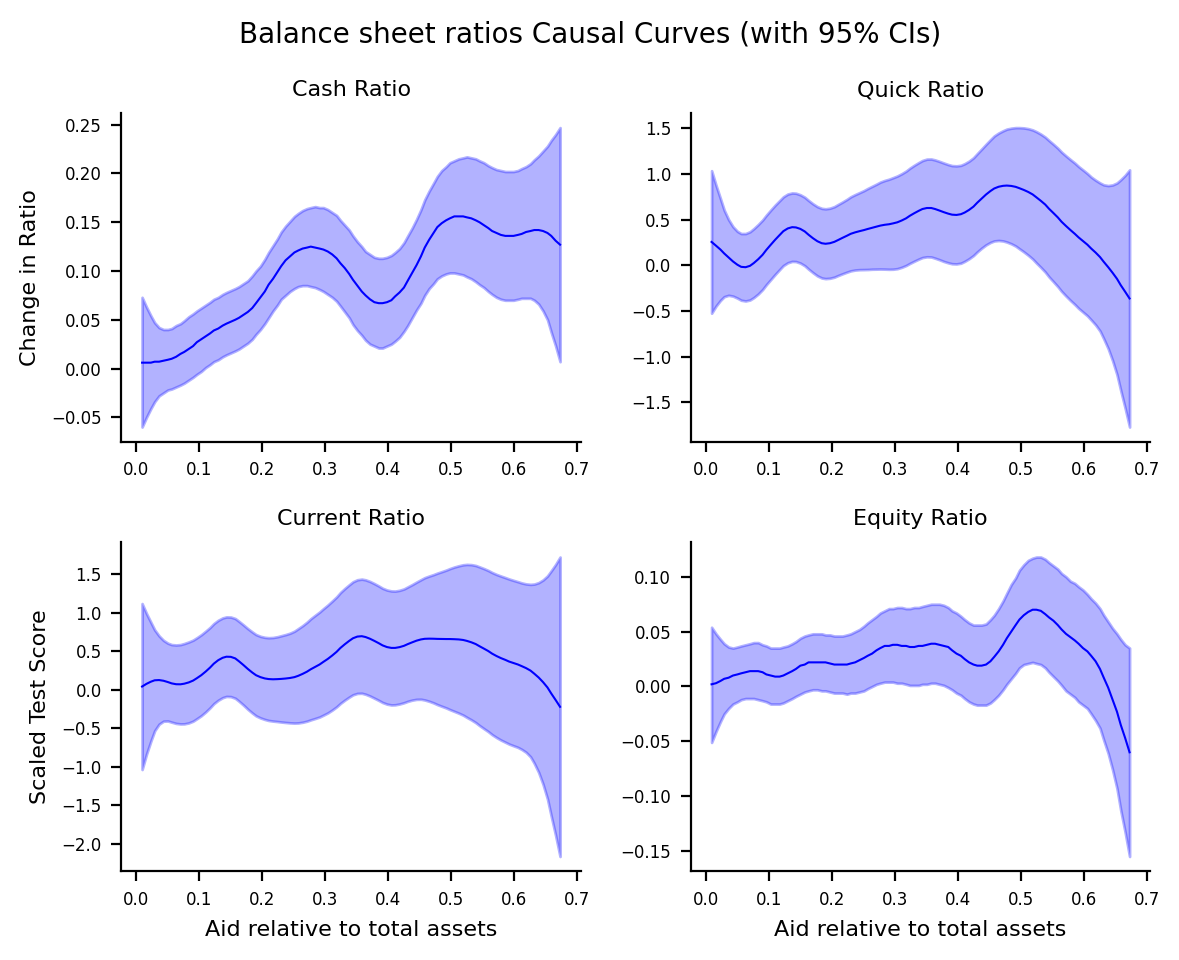

In [39]:
result_class = [['delta_cash_ratio_2021', 'delta_qick_ratio_2021'], ['delta_current_ratio_2021', 'delta_equity_ratio_2021']]

result_name = [['Cash Ratio', 'Quick Ratio'], ['Current Ratio', 'Equity Ratio']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Ratio', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 8)
        axs[1,1].set_xlabel('Aid relative to total assets', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        #axs[i,j].set_xlim(0, 2)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Balance sheet ratios Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

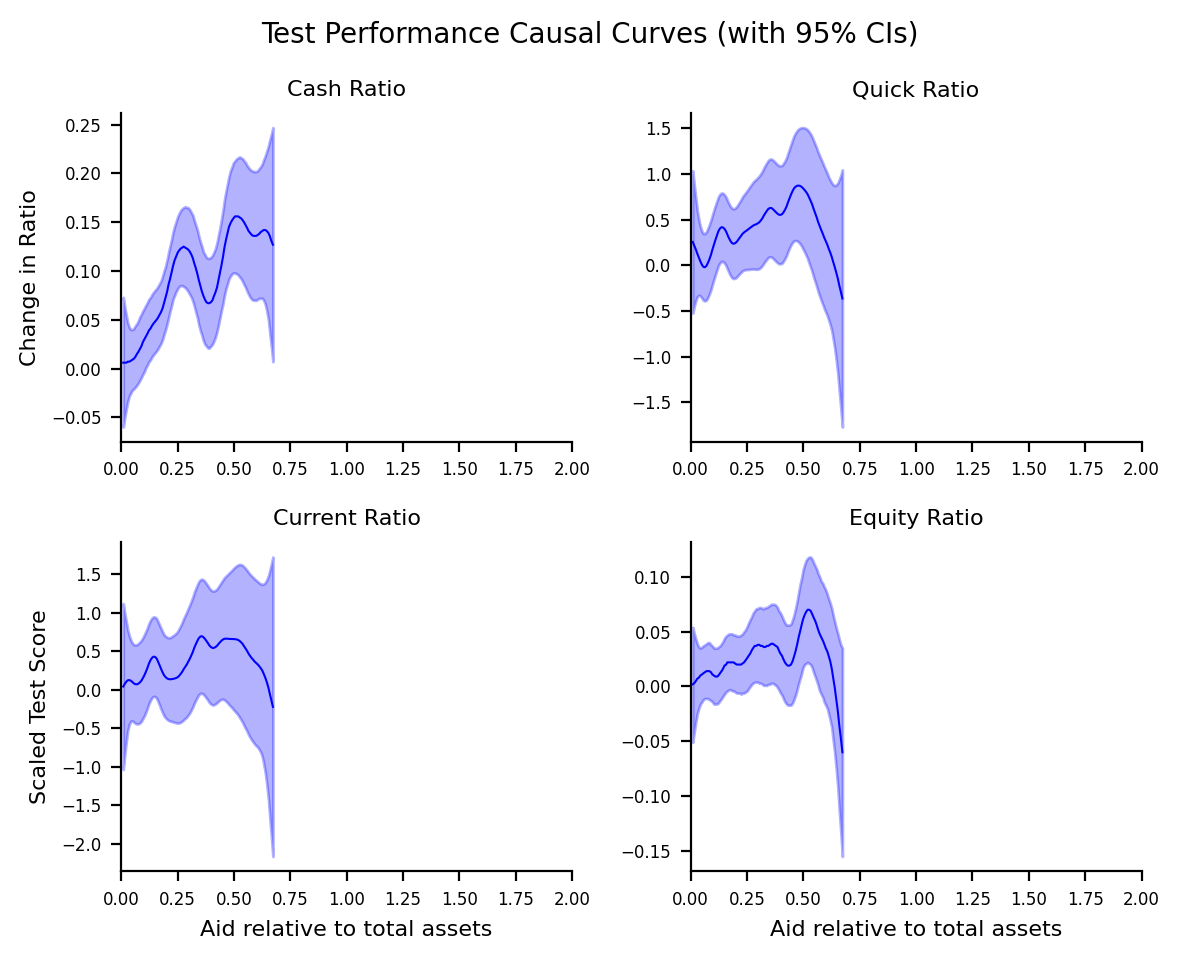

In [40]:
result_class = [['delta_cash_ratio_2021', 'delta_qick_ratio_2021'], ['delta_current_ratio_2021', 'delta_equity_ratio_2021']]

result_name = [['Cash Ratio', 'Quick Ratio'], ['Current Ratio', 'Equity Ratio']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Ratio', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 8)
        axs[1,1].set_xlabel('Aid relative to total assets', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        axs[i,j].set_xlim(0, 2)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Test Performance Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

In [41]:
# Dictionary to store model results
results_dict = {}

# Potential confounders
potential_confounders = list(condounders.columns)

# Try the MATH model
math_gps = TMLE_Regressor(random_seed=111,bandwidth=10)
#math_gps = GPS_Regressor()
math_gps.fit(
    T=final_df['aid_relative'], 
    X=final_df[potential_confounders], 
    y=final_df['delta_ratio']
)

results_dict['qick_ratio_2021'] = math_gps.calculate_CDRC()

KeyError: 'aid_relative'

In [ ]:
results_dict['math_CDRC'] = math_gps.calculate_CDRC()
results_dict['reading_CDRC'] = math_gps.calculate_CDRC()
results_dict['block_CDRC'] = math_gps.calculate_CDRC()
results_dict['digit_CDRC'] = math_gps.calculate_CDRC()

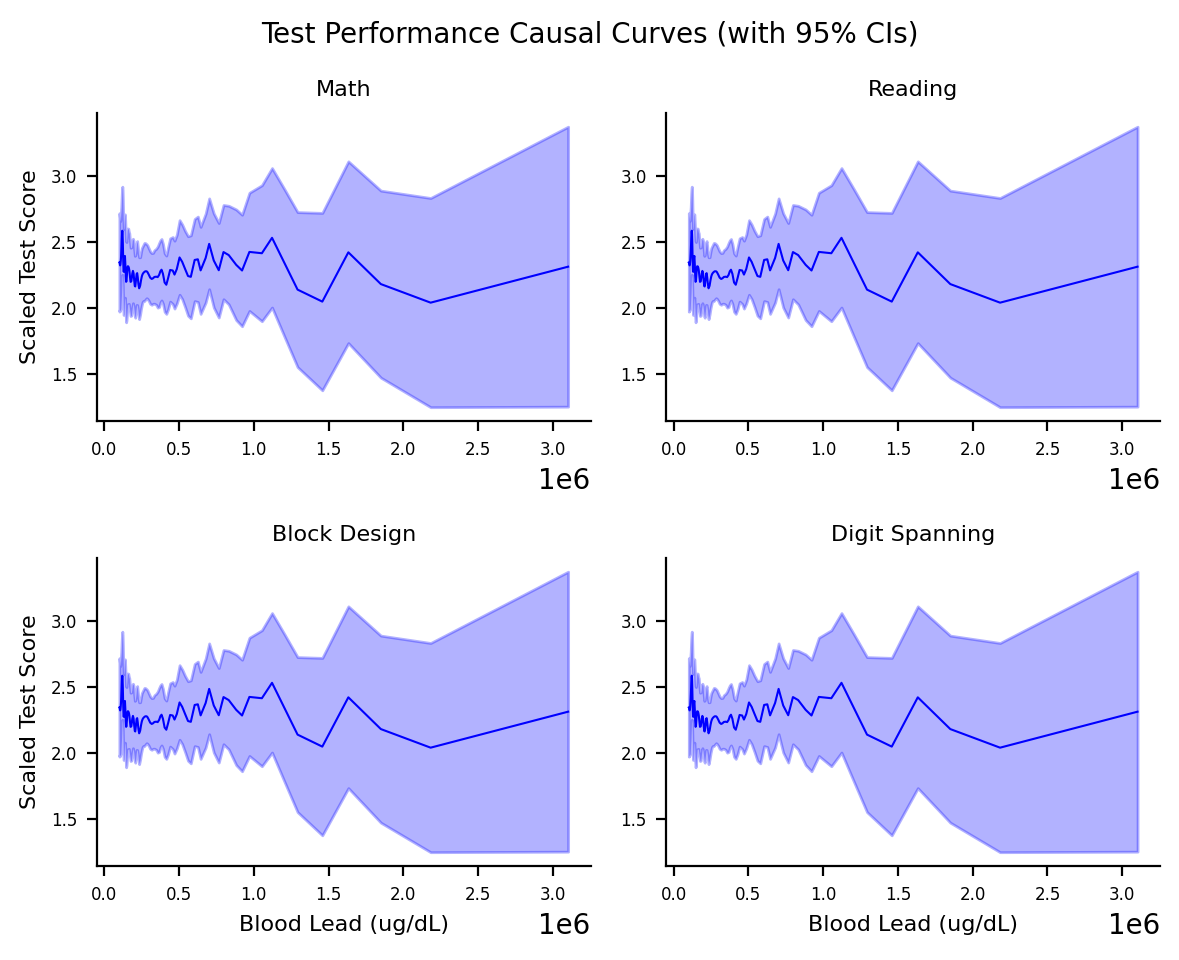

In [ ]:
result_class = [['math_CDRC', 'reading_CDRC'], ['block_CDRC', 'digit_CDRC']]

result_name = [['Math', 'Reading'], ['Block Design', 'Digit Spanning']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)
        axs[1,1].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        #axs[i,j].set_xlim(0, 10)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Test Performance Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

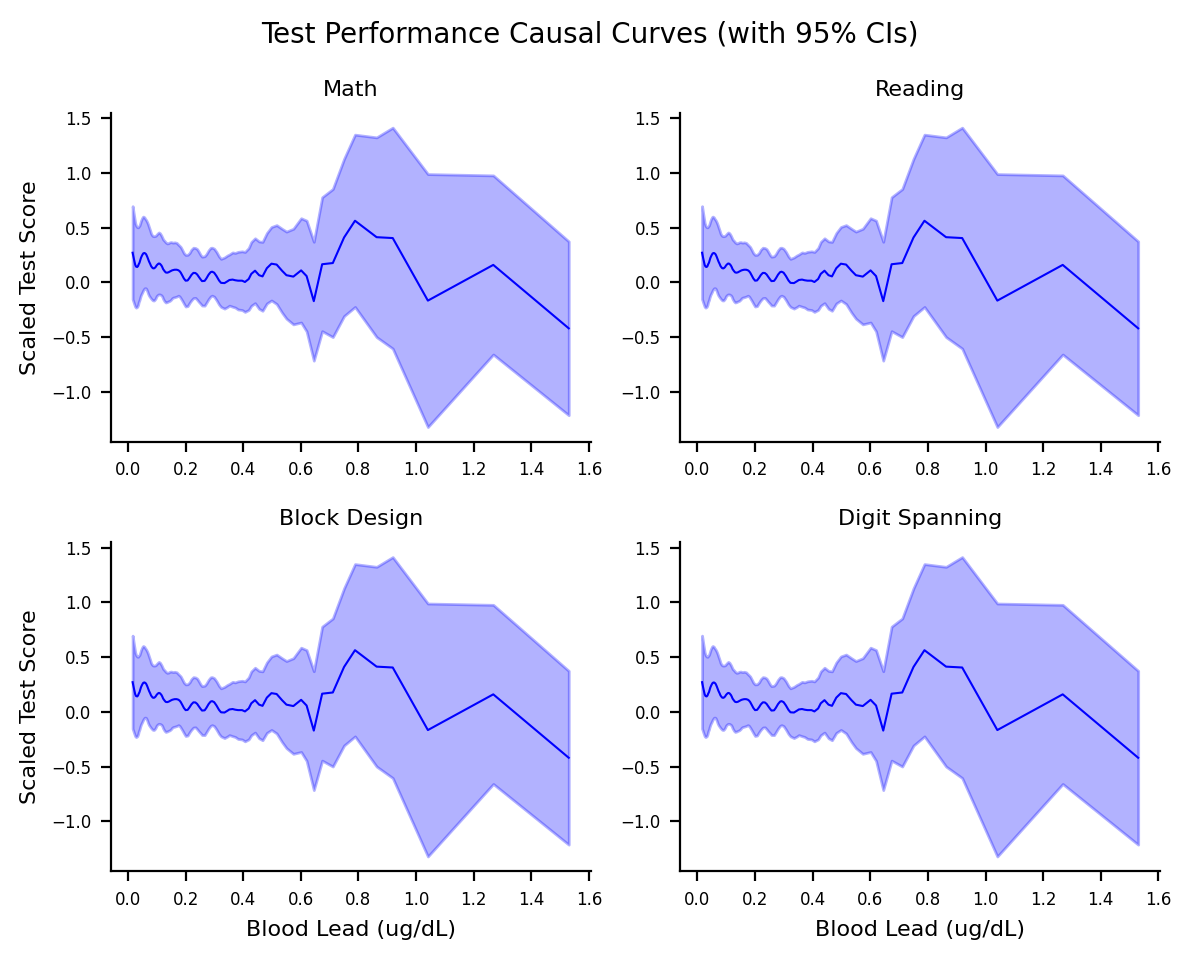

In [ ]:
result_class = [['math_CDRC', 'reading_CDRC'], ['block_CDRC', 'digit_CDRC']]

result_name = [['Math', 'Reading'], ['Block Design', 'Digit Spanning']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)
        axs[1,1].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        #axs[i,j].set_xlim(0, 10)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Test Performance Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

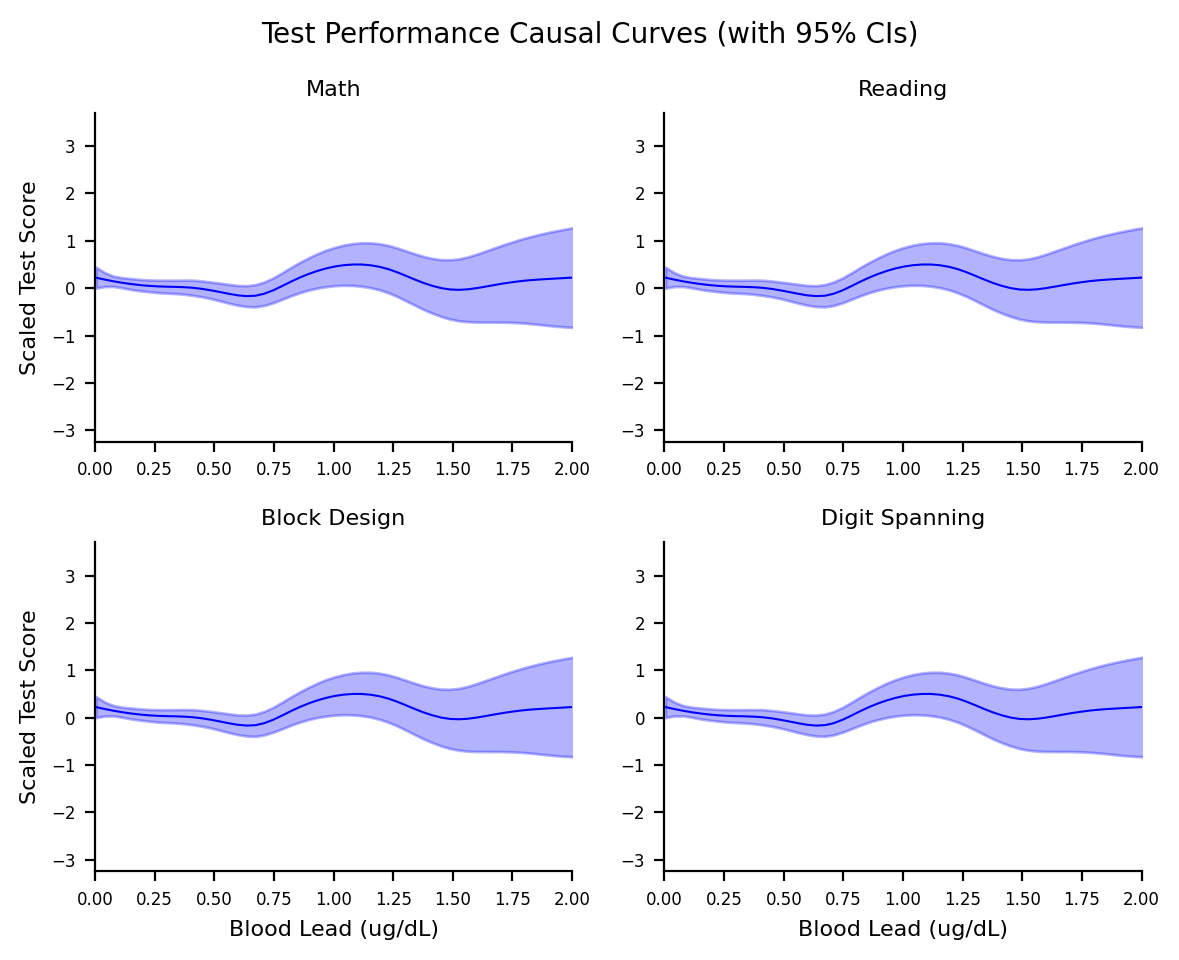

In [ ]:
result_class = [['math_CDRC', 'reading_CDRC'], ['block_CDRC', 'digit_CDRC']]

result_name = [['Math', 'Reading'], ['Block Design', 'Digit Spanning']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)
        axs[1,1].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        axs[i,j].set_xlim(0, 2)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Test Performance Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

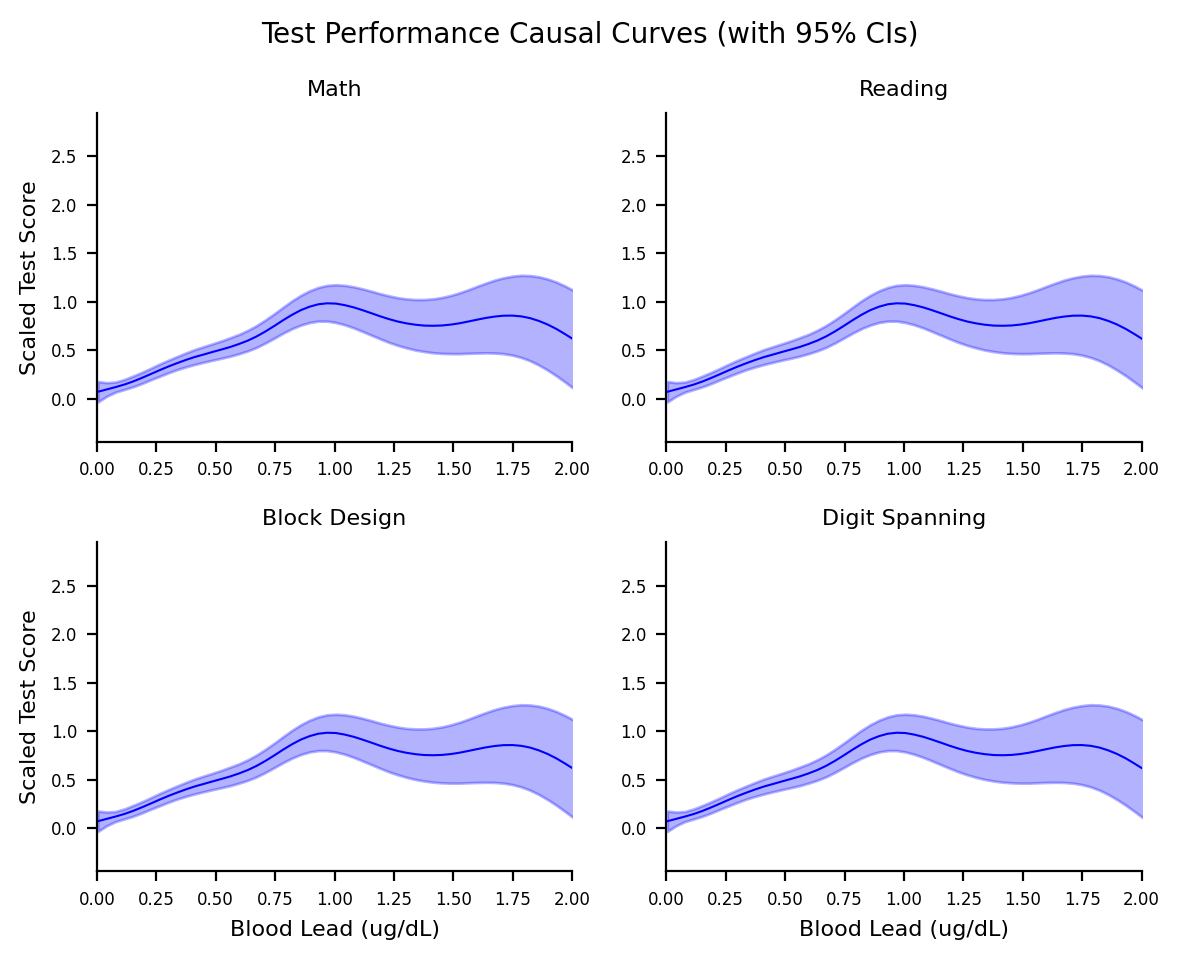

In [ ]:
result_class = [['math_CDRC', 'reading_CDRC'], ['block_CDRC', 'digit_CDRC']]

result_name = [['Math', 'Reading'], ['Block Design', 'Digit Spanning']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)
        axs[1,1].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        axs[i,j].set_xlim(0, 2)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Test Performance Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

In [ ]:
# Dictionary to store model results
results_dict = {}

# Potential confounders
potential_confounders = list(pd.get_dummies(df["industry_1"], prefix='industry', drop_first=True).columns)

# Try the MATH model
math_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)
math_gps.fit(
    T=df['BLL'], 
    X=df[potential_confounders], 
    y=df['Math']
)

results_dict['math_CDRC'] = math_gps.calculate_CDRC()


# Try the READING model
reading_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)

reading_gps.fit(
    T=df['BLL'], 
    X=df[potential_confounders],  
    y=df['Reading']
)

results_dict['reading_CDRC'] = reading_gps.calculate_CDRC()



# Try the Block model
block_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)

block_gps.fit(
    T=df['BLL'], 
    X=df[potential_confounders],  
    y=df['Block']
)

results_dict['block_CDRC'] = block_gps.calculate_CDRC()



# Try the Digit model
digit_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)

digit_gps.fit(
    T=df['BLL'], 
    X=df[potential_confounders],  
    y=df['Digit']
)

results_dict['digit_CDRC'] = digit_gps.calculate_CDRC()

### Data insights

In [480]:
merged_df = pd.read_csv('data/main/merged_data.csv')
test_df = merged_df
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [481]:
df_pivot = pd.wide_to_long(test_df, ["loan","current_ratio","current_liabilities","liabilities","qick_ratio","equity","equity_ratio","cash","assets","current_assets","cash_ratio","debt2asset_ratio","debt2equity_ratio"], i="company", j="year", sep="_")

In [482]:
df_pivot = df_pivot.reset_index()

In [168]:
# optional for looking at treatment groups
df_pivot = df_pivot[df_pivot['loan'].isna()]
df_pivot['cohort_2020'] = np.where((~df_pivot['grant_2020'].isna()) & (df_pivot['grant_2021'].isna()) & (df_pivot['grant_2022'].isna()) ,1,0)
df_pivot['cohort_2021'] = np.where((df_pivot['grant_2020'].isna()) & (~df_pivot['grant_2021'].isna()) & (df_pivot['grant_2022'].isna()) ,2,0)
df_pivot['cohort_2022'] = np.where((df_pivot['grant_2020'].isna()) & (df_pivot['grant_2021'].isna()) &  (~df_pivot['grant_2022'].isna()),3,0)
df_pivot['cohort'] = df_pivot['cohort_2020']+df_pivot['cohort_2021']+df_pivot['cohort_2022']


In [411]:
df_pivot

,company,year,grant_2022,grant_2020,industry,industry_1,size,grant_2021,industry_2,grant_2023,...,liabilities,qick_ratio,equity,equity_ratio,cash,assets,current_assets,cash_ratio,debt2asset_ratio,debt2equity_ratio
0,"""CEDON"" MuseumShops GmbH",2020,NaN,NaN,Sonstiger Einzelhandel in Verkaufsräumen (ohne...,Handel; Instandhaltung und Reparatur von Kraft...,nur Großunternehmen,NaN,Einzelhandel (ohne Handel mit Kraftfahrzeugen),NaN,...,1937804.31,1.507892,977972.87,0.331118,356456.98,2953545.57,2494337.15,0.120688,0.656094,1.981450
1,"""Capillar GmbH""",2020,NaN,NaN,Einzelhandel (ohne Handel mit Kraftfahrzeugen),Handel; Instandhaltung und Reparatur von Kraft...,Kleine und mittlere Unternehmen,NaN,Einzelhandel (ohne Handel mit Kraftfahrzeugen),NaN,...,1996968.98,1.356299,708137.73,0.259127,233693.31,2732777.71,1225767.05,0.085515,0.730747,2.820029
2,"""Der Pommeraner"" Loitz GmbH",2020,NaN,NaN,Fleischverarbeitung,Verarbeitendes Gewerbe,nur Großunternehmen,NaN,Herstellung von Nahrungs- und Futtermitteln,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"""Die Rakete"" Gastro GmbH",2020,NaN,NaN,Ausschank von Getränken,Gastgewerbe,nur Großunternehmen,NaN,Gastronomie,NaN,...,357494.81,4.643387,16636.11,0.036228,74102.15,459210.13,320787.82,0.161369,0.778499,21.489087
4,"""ECOMA"" Maschinen GmbH",2020,NaN,NaN,Herstellung von Maschinen für sonstige bestimm...,Verarbeitendes Gewerbe,nur Großunternehmen,NaN,Maschinenbau,NaN,...,1648004.43,0.231484,0.00,0.000000,325.42,1687367.43,1187927.95,0.000193,0.976672,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117910,ÜberQuell GmbH,2019,NaN,NaN,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastgewerbe,Kleine und mittlere Unternehmen,421111.0,Gastronomie,NaN,...,1692158.61,0.090197,0.00,0.000000,9972.35,1976323.34,272819.28,0.005046,0.856215,inf
117911,Überfluss Hotelbetriebsgesellschaft mbH,2019,739038.0,NaN,"Hotels, Gasthöfe und Pensionen",Gastgewerbe,Kleine und mittlere Unternehmen,1061559.0,Beherbergung,NaN,...,660530.66,2.951252,49775.14,0.069732,215332.33,713805.80,636005.80,0.301668,0.925365,13.270292
117912,Ürer Mobilfunk GmbH,2019,103358.0,NaN,Einzelhandel mit Telekommunikationsgeräten,Handel; Instandhaltung und Reparatur von Kraft...,Kleine und mittlere Unternehmen,NaN,Einzelhandel (ohne Handel mit Kraftfahrzeugen),NaN,...,184793.24,3.189870,314606.21,0.605257,96062.14,519789.45,452540.16,0.184810,0.355516,0.587380
117913,überland Reisen Berlin GmbH,2019,NaN,NaN,Reiseveranstalter,Erbringung von sonstigen wirtschaftlichen Dien...,Kleine und mittlere Unternehmen,228885.0,"Reisebüros, Reiseveranstalter und Erbringung s...",NaN,...,218803.66,1.582294,109543.44,0.295723,258708.54,370426.25,369249.25,0.698408,0.590681,1.997415


In [403]:
df_pivot.groupby(["year"])["cash",'assets','liabilities'].mean().dropna().reset_index()

,year,cash,assets,liabilities
0,2018,240873.096442,2.019797e+06,1.174979e+06
1,2019,243378.134643,2.055758e+06,1.209375e+06
2,2020,305985.084007,2.440626e+06,1.374417e+06
3,2021,437487.582475,2.960837e+06,1.555012e+06


In [ ]:
df_pivot.groupby(["year"])["cash",'assets','liabilities'].count().reset_index()

In [483]:
df_pivot.groupby(["year"])["cash",'assets','liabilities'].mean().pct_change(fill_method='pad').fillna(0).reset_index()

,year,cash,assets,liabilities
0,2018,0.000000,0.000000,0.000000
1,2019,0.010400,0.017805,0.029274
2,2020,0.257241,0.187214,0.136469
3,2021,0.429768,0.213146,0.131398
4,2022,0.000000,0.000000,0.000000


In [484]:
df_pivot.groupby(["year"])["cash",'assets','liabilities'].mean().pct_change().cumsum(axis=0)

,cash,assets,liabilities
year,,,
2018,NaN,NaN,NaN
2019,0.010400,0.017805,0.029274
2020,0.267641,0.205019,0.165743
2021,0.697409,0.418165,0.297140
2022,0.697409,0.418165,0.297140


In [477]:
df_pivot.groupby(["year"])["cash",'assets','liabilities'].mean().dropna().pct_change(fill_method='pad').fillna(0).cumsum(axis=0).reset_index()

,year,cash,assets,liabilities
0,2018,0.000000,0.000000,0.000000
1,2019,0.010400,0.017805,0.029274
2,2020,0.267641,0.205019,0.165743
3,2021,0.697409,0.418165,0.297140


<Axes: xlabel='year'>

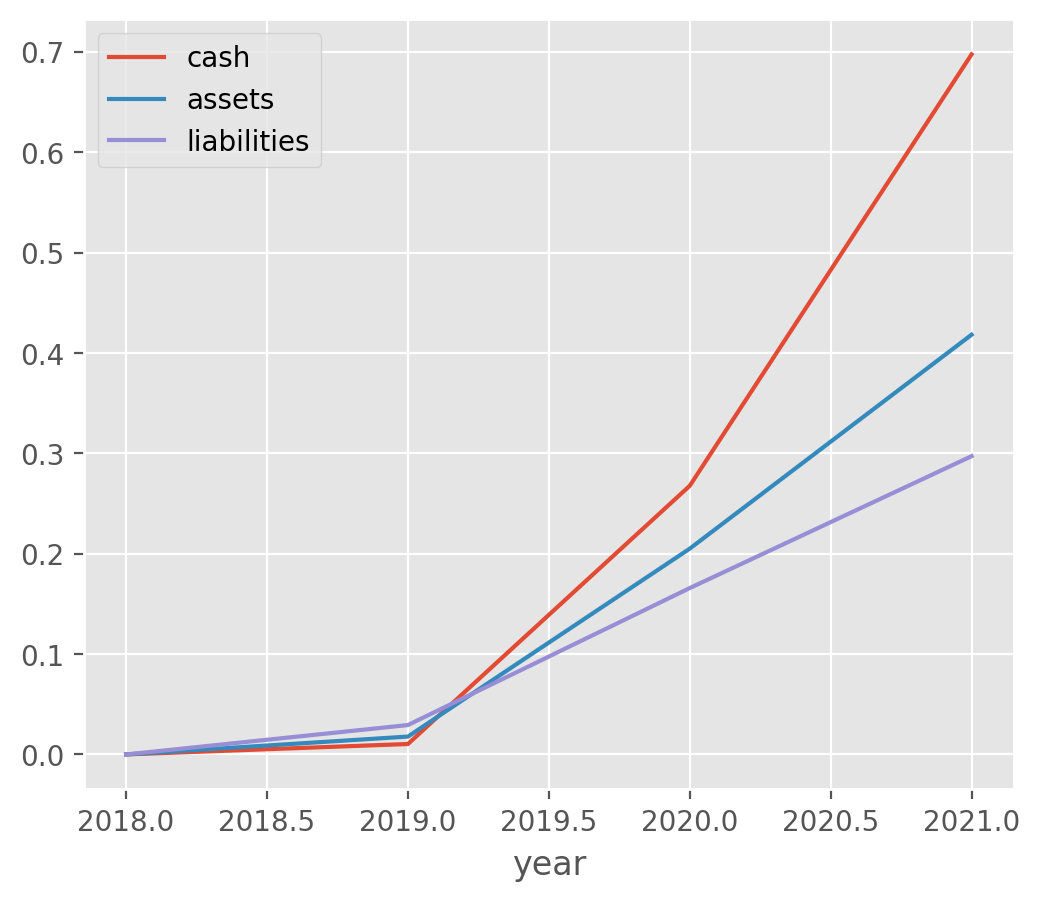

In [418]:
df_pivot.groupby(["year"])["cash",'assets','liabilities'].mean().dropna().pct_change(fill_method='pad').fillna(0).cumsum(axis=0).reset_index().plot('year')

<Axes: xlabel='year'>

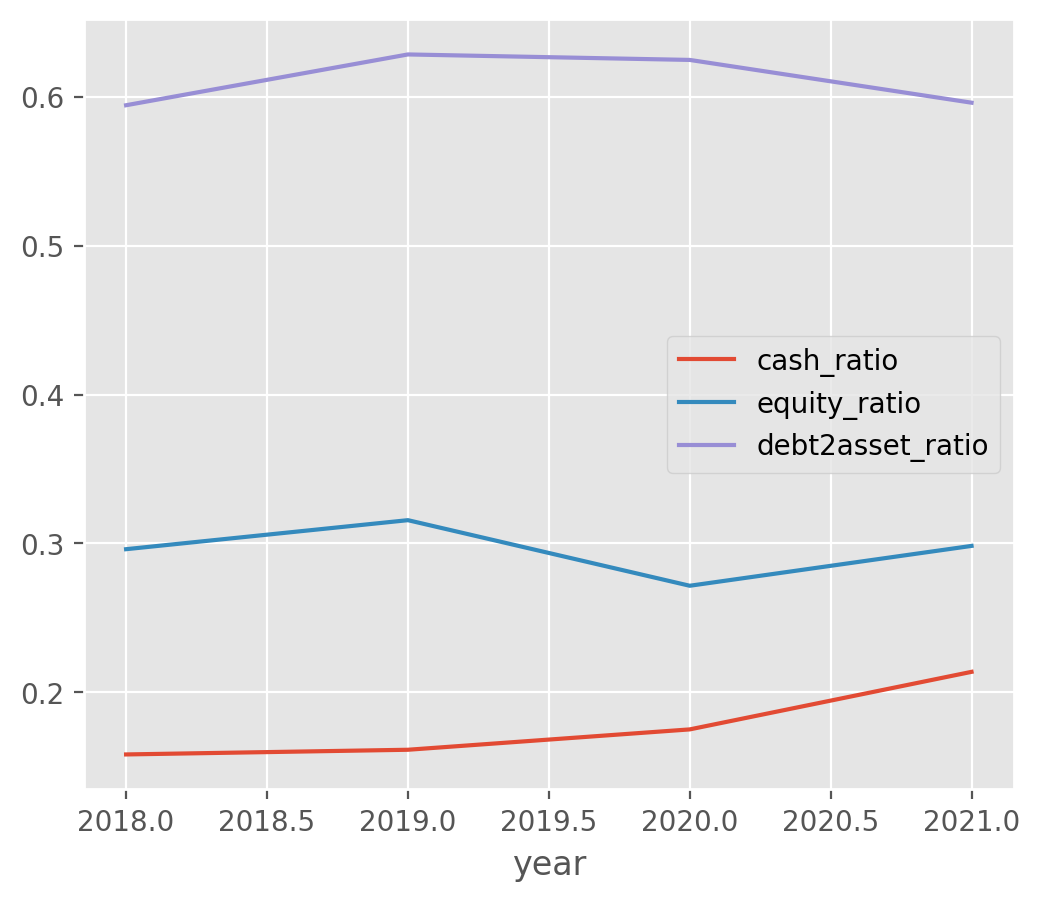

In [497]:
df_pivot.groupby(["year"])["cash_ratio","equity_ratio","debt2asset_ratio"].mean().dropna().reset_index().plot('year')

In [489]:
df_pivot.groupby(['year'])['cash_ratio'].mean().plot('year')

TypeError: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='year')` instead of `Series.plot('year',)`.

In [494]:
df_pivot.pivot_table(columns='year',    aggfunc=np.mean)

year,2018,2019,2020,2021,2022
assets,2.019797e+06,2.055758e+06,2.440626e+06,2.960837e+06,NaN
cash,2.408731e+05,2.433781e+05,3.059851e+05,4.374876e+05,NaN
cash_ratio,1.582594e-01,1.614078e-01,1.750853e-01,2.137520e-01,NaN
current_assets,1.182241e+06,1.211242e+06,1.376161e+06,1.740070e+06,NaN
current_liabilities,1.036497e+06,1.068307e+06,1.059553e+06,1.161225e+06,NaN
current_ratio,6.087735e+00,4.772864e+00,9.562897e+00,1.112737e+01,NaN
debt2asset_ratio,5.944031e-01,6.285257e-01,6.248438e-01,5.961132e-01,NaN
debt2equity_ratio,3.039094e+02,2.169153e+01,1.323962e+02,4.233709e+01,NaN
equity,6.494037e+05,6.605642e+05,8.063077e+05,1.015634e+06,NaN
equity_ratio,2.961510e-01,3.156470e-01,2.715837e-01,2.983609e-01,NaN


In [479]:
df_pivot.aggregate('mean')

year                   2.020000e+03
grant_2022             4.319729e+05
grant_2020             1.807120e+05
grant_2021             4.571920e+05
grant_2023             5.430210e+05
loan                   4.645106e+05
current_ratio                   inf
current_liabilities    1.073837e+06
liabilities            1.309485e+06
qick_ratio                      NaN
equity                 7.622963e+05
equity_ratio                    inf
cash                   2.948026e+05
assets                 2.317196e+06
current_assets         1.344183e+06
cash_ratio                      inf
debt2asset_ratio                inf
debt2equity_ratio               NaN
dtype: float64